In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/samsungmlengineer/FaultyDataset.csv
/kaggle/input/samsungmlengineer/HealthyDataset.csv


# **import the libraries and load the data**

In [23]:
# !pip install pandas-profiling
# !pip install pytorch-tabnet

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
%matplotlib inline
import joblib

In [6]:
def data_read():
    '''
    objective: reading and combining the data.
    return: final data frame(faulty+healhy)
    '''
    col=['sensor1','sensor2','sensor3','sensor4']
    df_faulty=pd.read_csv('/kaggle/input/samsungmlengineer/FaultyDataset.csv',header=None,names=col)
    df_faulty['y']=1
    
    df_healthy=pd.read_csv('/kaggle/input/samsungmlengineer/HealthyDataset.csv',header=None,names=col)
    df_healthy['y']=0
    
    combined_df=pd.concat([df_faulty,df_healthy],axis=0,ignore_index=True)
    return combined_df

In [7]:
combined_df=data_read()

In [43]:
combined_df.shape     

(194048, 5)

# EDA

In [67]:
combined_df.describe(include='all')

,sensor1,sensor2,sensor3,sensor4,y
count,194048.000000,194048.000000,194048.000000,194048.000000,194048.000000
mean,-0.001512,-0.001062,0.001076,0.007396,0.485488
std,6.689933,4.488596,4.218789,4.891122,0.499791
min,-50.800000,-28.600000,-27.000000,-31.300000,0.000000
25%,-3.720000,-2.570000,-2.370000,-2.700000,0.000000
50%,-0.184000,0.119000,0.069900,0.202000,0.000000
75%,3.530000,2.750000,2.440000,2.860000,1.000000
max,52.700000,28.400000,25.100000,33.400000,1.000000


<AxesSubplot:>

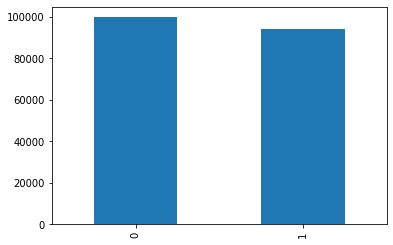

In [15]:
combined_df['y'].value_counts().plot(kind='bar')

In [8]:
combined_df['y'].value_counts(normalize=True)*100

0    51.451187
1    48.548813
Name: y, dtype: float64

In [26]:
profile = ProfileReport(combined_df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**EDA Report**
- we have got 194048 data points in total.
- there are 4 features we have and all are numerical continuous variables.
- luckily there are no missing and duplicate values.
- features are in different scales, we need to normalize them in the final preprocessing step.
- i'm considering the data i have got in healthy.csv as the healthy class which is represented as 0 and faulty.csv as faulty class which is represented as 1.
- data distribution for target variable is almost balanced.
- all the sensor data we have got is almost normally distributed.

# **Preprocessing**

In [8]:
def preprocess(combined_df):
    '''
    objective: preprocess the data frame for modelling
    combined_df: combined dataframe(faulty+healthy)
    return: X & Y - train, test data set.
    
    '''
    col_x=combined_df.columns[~combined_df.columns.isin(['y'])]
    X=combined_df[col_x]
    y=combined_df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)
    joblib.dump(scaler, "scale.joblib", 9) # export the scaler for inference
    
    return X_train,X_test, y_train,y_test
X_train,X_test, y_train,y_test=preprocess(combined_df)

In [15]:
y_train.value_counts(normalize='True')*100

0    51.479863
1    48.520137
Name: y, dtype: float64

In [11]:
y_test.value_counts(normalize='True')*100

0    51.392966
1    48.607034
Name: y, dtype: float64

In [9]:
def loss(actual,pred):
    '''
    objective: f1 score calculation.
    prediction: precited values
    actual: actual values
    return: f1 score for the model.
    '''
    return f1_score(actual, pred)

In [10]:
def validation(X_train,y_train,model):
    '''
    objective: validation loop to validate the model performace.
    X_train: independent variables of training data.
    y_train: dependent/target variable of training data.
    
    '''
    print("---------",model,"------------")
    kfold=StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    train_los=0
    test_los=0
    for fold,(train_idx, val_idx) in enumerate(kfold.split(X_train,y_train)):
        train_x=X_train[train_idx]
        train_y=y_train[train_idx]
        test_x=X_train[val_idx]
        test_y=y_train[val_idx]
        model.fit(train_x,train_y)
        pred_test=model.predict(test_x)
        pred_train=model.predict(train_x)
        train_los+=loss(train_y,pred_train)
        test_los+=loss(test_y,pred_test)
        print(fold,'train loss------->',loss(train_y,pred_train))
        print(fold,'test loss------->',loss(test_y,pred_test))
    print('train',train_los/5)
    print("test",test_los/5)
    return "----------end--------------"

In [16]:
#dt,rf, xgb are hyper parameter tuned models.
dt=DecisionTreeClassifier(min_samples_split=7,min_samples_leaf=5,max_depth=None,random_state=42)
rf=RandomForestClassifier(random_state=0,n_estimators=100,min_samples_split=2,min_samples_leaf=1,
                           max_features='sqrt', max_depth=10,bootstrap=False)
clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)
models=[dt, rf, ExtraTreesClassifier(random_state=0),KNeighborsClassifier(),clf_xgb]
for model in models:
    validation(X_train,y_train.values,model)

--------- DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=7, random_state=42) ------------
0 train loss-------> 0.8276363636363636
0 test loss-------> 0.5392137137338538
1 train loss-------> 0.8281126931232959
1 test loss-------> 0.5357720945289738
2 train loss-------> 0.8293300891806837
2 test loss-------> 0.5451975119153405
3 train loss-------> 0.8291074336959362
3 test loss-------> 0.548211134285256
4 train loss-------> 0.8285650965064271
4 test loss-------> 0.5417762492413515
train 0.8285503352285414
test 0.5420341407409552
--------- RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       random_state=0) ------------
0 train loss-------> 0.6936554884399084
0 test loss-------> 0.6721900578957877
1 train loss-------> 0.6970865573607343
1 test loss-------> 0.6700036707044417
2 train loss-------> 0.6944026594639519
2 test loss-------> 0.6732257203842049
3 train loss-------> 0.6970066994488631
3 test loss-------> 0.6775872931657658


In [11]:
def train_test(model, X_train, y_train, X_test,y_test):
    '''
    objective: model performances on train and test set.
    X_train: independent variables of training data.
    y_train: dependent/target variable of training data.
    X_test: independent variables of test data.
    y_test: dependent/target variable of test data.
    
    '''
    print("----------", model,"-----------")
    model.fit(X_train, y_train)
    pred=model.predict(X_train)
    print("train_accuracy",f1_score(y_train, pred))
    pred_test=model.predict(X_test)
    print("test_accuracy",f1_score(y_test, pred_test))

In [20]:
for model in models:
    train_test(model,X_train,y_train.values,X_test,y_test)

---------- DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=7, random_state=42) -----------
train_accuracy 0.8281301612110566
test_accuracy 0.5419985932311517
---------- RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       random_state=0) -----------
train_accuracy 0.692124770837208
test_accuracy 0.6754479392770955
---------- ExtraTreesClassifier(random_state=0) -----------
train_accuracy 1.0
test_accuracy 0.6015761685788162
---------- KNeighborsClassifier() -----------
train_accuracy 0.7251290528843904
test_accuracy 0.5759860880562802
---------- XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=2

**modeling conclusion:**
- xgb and RF are performing almost similar accuracy wise but rf has slightly better accuracy and fast. hence rf is considered for the final modelling.

# **model export**

In [12]:
import time
start_time = time.clock()
rf=RandomForestClassifier(random_state=0,n_estimators=100,min_samples_split=2,min_samples_leaf=1,
                           max_features='sqrt', max_depth=10,bootstrap=False)
rf.fit(X_train, y_train)
pred=rf.predict(X_train)
print(time.clock() - start_time, "seconds")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


36.665827 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [13]:
prediction=rf.predict(X_test)
loss(prediction,y_test)

0.6754479392770955

In [14]:
import joblib
joblib.dump(rf, "model_rf.joblib", 9)

['model_rf.joblib']

In [15]:
modrf=joblib.load("model_rf.joblib", mmap_mode=None)

<AxesSubplot:>

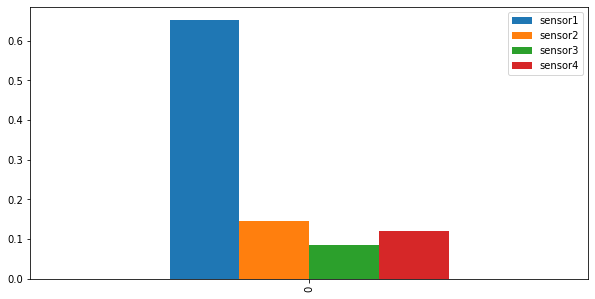

In [16]:
col=['sensor1','sensor2','sensor3','sensor4']
pd.DataFrame([rf.feature_importances_],columns=col).plot.bar(figsize=(10,5))

# **Hyper Parameter Tuning**

**Random Forest**

In [ ]:
# uncomment this cell to run the hyper parameter tuning
# random_grid={'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
# }
# rf_random = RandomizedSearchCV(estimator = dt_clf, param_distributions = random_grid, n_iter = 100, 
#                                cv = 3, verbose=2, random_state=42, n_jobs = -1)
# search = rf_random.fit(X_train, y_train)
# rf_random.best_params_

In [34]:
# model=RandomForestClassifier(random_state=0,n_estimators=100,min_samples_split=2,min_samples_leaf=1,
#                            max_features='sqrt', max_depth=10,bootstrap=False)
# validation(X_train,y_train.values,model)

--------- RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       random_state=0) ------------
0 train loss-------> 0.6936554884399084
0 test loss-------> 0.6721900578957877
1 train loss-------> 0.6970865573607343
1 test loss-------> 0.6700036707044417
2 train loss-------> 0.6944026594639519
2 test loss-------> 0.6732257203842049
3 train loss-------> 0.6970066994488631
3 test loss-------> 0.6775872931657658
4 train loss-------> 0.6968653231548793
4 test loss-------> 0.6699644766110023
train 0.6958033455736674
test 0.6725942437522405


'----------end--------------'

In [ ]:
# model=RandomForestClassifier(random_state=0,n_estimators=100,min_samples_split=2,min_samples_leaf=1,
#                            max_features='sqrt', max_depth=10,bootstrap=False)
# model.fit(X_train,y_train)
# pred_train=model.predict(X_train)
# pred_test=model.predict(X_test)
# print(loss(pred_train,y_train))
# print(loss(pred_test,y_test))

**XGB tuning**

In [ ]:
clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)
clf_xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=10,
        verbose=10)


# **Advanced Modelling Techniques**

**Tabnet**

In [37]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
np.random.seed(0)
tabnet_params = {
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )
max_epochs = 100 if not os.getenv("CI", False) else 2


/opt/conda/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [38]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False, #aug, None
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.6561  | train_auc: 0.52164 | valid_auc: 0.52317 |  0:00:09s
epoch 1  | loss: 0.63828 | train_auc: 0.61017 | valid_auc: 0.61018 |  0:00:17s
epoch 2  | loss: 0.63602 | train_auc: 0.65671 | valid_auc: 0.65685 |  0:00:27s
epoch 3  | loss: 0.63547 | train_auc: 0.6699  | valid_auc: 0.66923 |  0:00:36s
epoch 4  | loss: 0.63335 | train_auc: 0.67081 | valid_auc: 0.6692  |  0:00:45s
epoch 5  | loss: 0.63474 | train_auc: 0.6732  | valid_auc: 0.67122 |  0:00:54s
epoch 6  | loss: 0.63397 | train_auc: 0.67328 | valid_auc: 0.67249 |  0:01:03s
epoch 7  | loss: 0.63209 | train_auc: 0.67372 | valid_auc: 0.67245 |  0:01:12s
epoch 8  | loss: 0.63253 | train_auc: 0.67301 | valid_auc: 0.67172 |  0:01:21s
epoch 9  | loss: 0.6302  | train_auc: 0.6763  | valid_auc: 0.67356 |  0:01:30s
epoch 10 | loss: 0.63176 | train_auc: 0.67626 | valid_auc: 0.67484 |  0:01:39s
epoch 11 | loss: 0.63069 | train_auc: 0.67763 | valid_auc: 0.67624 |  0:01:48s
epoch 12 | loss: 0.63134 | train_auc: 0.67677 | vali

/opt/conda/lib/python3.7/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.6561  | train_auc: 0.52164 | valid_auc: 0.52317 |  0:00:09s
epoch 1  | loss: 0.63828 | train_auc: 0.61017 | valid_auc: 0.61018 |  0:00:18s
epoch 2  | loss: 0.63602 | train_auc: 0.65671 | valid_auc: 0.65685 |  0:00:27s
epoch 3  | loss: 0.63547 | train_auc: 0.6699  | valid_auc: 0.66923 |  0:00:36s
epoch 4  | loss: 0.63335 | train_auc: 0.67081 | valid_auc: 0.6692  |  0:00:45s
epoch 5  | loss: 0.63474 | train_auc: 0.6732  | valid_auc: 0.67122 |  0:00:54s
epoch 6  | loss: 0.63397 | train_auc: 0.67328 | valid_auc: 0.67249 |  0:01:03s
epoch 7  | loss: 0.63209 | train_auc: 0.67372 | valid_auc: 0.67245 |  0:01:12s
epoch 8  | loss: 0.63253 | train_auc: 0.67301 | valid_auc: 0.67172 |  0:01:21s
epoch 9  | loss: 0.6302  | train_auc: 0.6763  | valid_auc: 0.67356 |  0:01:30s
epoch 10 | loss: 0.63176 | train_auc: 0.67626 | valid_auc: 0.67484 |  0:01:39s
epoch 11 | loss: 0.63069 | train_auc: 0.67763 | valid_auc: 0.67624 |  0:01:48s
epoch 12 | loss: 0.63134 | train_auc: 0.67677 | vali

/opt/conda/lib/python3.7/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


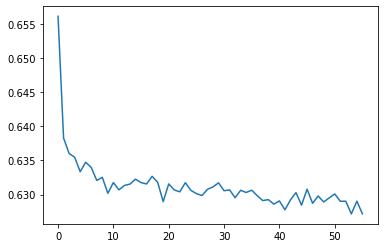

In [39]:
from matplotlib import pyplot as plt
plt.plot(clf.history['loss'])

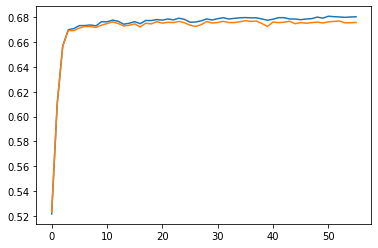

In [40]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

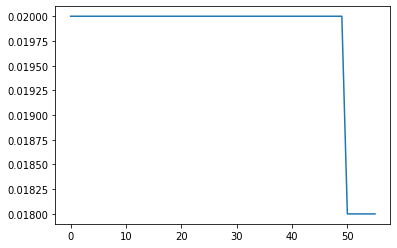

In [41]:
plt.plot(clf.history['lr'])

In [42]:
clf.feature_importances_

array([0.3783605 , 0.32522004, 0.20899948, 0.08741998])

In [43]:
pt=clf.predict(X_test)
loss(pt,y_test)

0.666292843625149

In [44]:
pt_tr=clf.predict(X_train)
loss(pt_tr,y_train)

0.6657309197516352

In [ ]:
import time
start_time = time.clock()
pt2=clf_xgb.predict(X_test)
loss(pt2,y_test)

# **Inference**

In [31]:
val=[[0.0,0.0,0.0,0.0]]
col=['sensor1','sensor2','sensor3','sensor4']
data=pd.DataFrame(val,columns=col)
data.head()

,sensor1,sensor2,sensor3,sensor4
0,0.0,0.0,0.0,0.0


In [32]:
import time
start_time = time.clock()
scale=joblib.load("scale.joblib", mmap_mode=None)
df=scale.transform(data)
final_model=joblib.load("model_rf.joblib", mmap_mode=None)
final_model.predict(df)

print(time.clock() - start_time, "seconds")

0.13751400000000302 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
